***
# **Práctico 3**
***

En este práctico estaremos realizando el preprocesamiento de datos, identificación de ASVs con [DADA2](https://benjjneb.github.io/dada2/), anotación taxonómica, e incluiremos además algunas visualizaciones.

---
Las tareas a realizar son las siguientes:
 1. Instalación de dependencias
 2. Definición de funciones
 3. Ubicación de datos
 4. Eliminación de primers
 5. Control de calidad
 6. Modelado de errores
 7. Dereplicado
 8. Identificación de ASVs
 9. Ensamblado de secuencias pares
 10. Creación de la matriz de abundancias
 11. Eliminación de bimeras
 12. Rastreo de secuencias
 13. Anotación taxonómica
--- 

---
### 1. Instalación de dependencias
---

Vamos primero que nada vamos a instalar las dependencias que precisamos en este flujo de trabajo.

- [cutadapt](https://cutadapt.readthedocs.io/en/stable/)  
- [BiocManager](https://cran.r-project.org/web/packages/BiocManager/index.html)  
- [DADA2](https://bioconductor.org/packages/release/bioc/html/dada2.html)  
- [ShortRead](https://bioconductor.org/packages/release/bioc/html/ShortRead.html)  
- [Biostrings](https://bioconductor.org/packages/release/bioc/html/Biostrings.html)  
- [tidyverse](https://www.tidyverse.org/)  
- [doParallel](https://cran.r-project.org/web/packages/doParallel/index.html)

Para quienes estén trabajando en el servidor del CURE, no será necesario realizar las instalaciones. Ya está todo instalado.

Empezamos con [cutadapt](https://cutadapt.readthedocs.io/en/stable/), la cual puedes instalar simplemente con el comando `sudo apt install cutadapt` o `pip install cutadapt`.  Existen otras opciones que puedes ver [acá](https://cutadapt.readthedocs.io/en/stable/installation.html).

Ahora vamos a hacer las instalaciones de todos los paquetes desde R.

Primero BiocManager, el cual nos permitirá instalar paquetes de bioconductor.

In [1]:
# install.packages("BiocManager")

Ahora podemos instalar DADA2, Biostrings y ShortRead.

In [2]:
# BiocManager::install("dada2")

In [3]:
# BiocManager::install("Biostrings")

In [4]:
# BiocManager::install("ShortRead")

[tidyverse](https://www.tidyverse.org/) y [doParallel](https://cran.r-project.org/web/packages/doParallel/index.html) los podemos instalar directo del [CRAN](https://cran.r-project.org/).

In [5]:
# install.packages("tidyverse")

In [6]:
# install.packages("doParallel")

Una vez instaladas todas las funciones, las cargamos a nuestro ambiente:

In [7]:
library(dada2)
library(Biostrings)
library(ShortRead)
library(tidyverse)
library(doParallel)

Loading required package: Rcpp

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: XVector

Loading required package: GenomeInfoDb


Attaching package: ‘Biostrings’


The following 

doParallel nos permite correr procesos en paralelo permitiendo reducir el tiempo de cómputo.  
Para esto, luego cargar la librería, debemos especificar cuántos hilos vamos utilizar, lo que realizamos con el siguiente comando.

In [8]:
registerDoParallel(cores = 4)

Puedes averiguar cuántos hilos tienes en tu computadora con la función [detectCores](https://www.rdocumentation.org/packages/parallel/versions/3.6.2/topics/detectCores).

---
### 2. Definición de funciones
---

Vamos a definirnos una funciones en R, muy útiles para la identificación y eliminación de _primers_.  
Debo aclarar que el código que aparece abajo es una modificación de lo que aparece en el tutorial de [DADA2](https://benjjneb.github.io/dada2/tutorial_1_8.html).

**Función 1**: `all_orients`  
Esta función lo que hace es, para cada secuencia de entrada (en nuestro caso un _primer_), genera su versión complementaria, reversa y reversa complementaria.

In [9]:
all_orients <- function(PRIMER) {
  require(Biostrings)
  DNA <- DNAString(PRIMER)  
  orients <- c(Forward = DNA, 
               Complement = complement(DNA), 
               Reverse = reverse(DNA), 
               RevComp = reverseComplement(DNA))
  return(sapply(orients, toString)) 
}

**Función 2**: `primer_hits`  
Esta función cuenta el número de veces en que una secuencia problema (en nuestro caso un _primer_) es encontrada en una muestra de amplicones en formato fastq.

In [10]:
primer_hits <- function(PRIMER, INPUT) {
  require(ShortRead) 
  require(Biostrings) 
  nhits <- vcountPattern(pattern = PRIMER, 
                         subject = sread(readFastq(INPUT)), 
                         fixed = FALSE)
  return(sum(nhits > 0))
}

**Función 3**: `run_cutadapt`  
Como su nombre lo indica, esta función lo que hace es correr `cutadapt` desde R, lo que se conoce como _wrapper_.

Para definir esta función, primero vamos a averiguar dónde quedó instalada la herramienta `cutadapt` en nuestra computadora. Esto lo deberíamos correr desde la línea de comando, pero también lo podemos hacer desde R utilizando la función [system2](https://www.rdocumentation.org/packages/base/versions/3.6.2/topics/system2), como aparece abajo.

In [11]:
cutadapt <- system2("which", "cutadapt")

En el caso de haber instalado `cutadapt` con `sudo apt install cutadapt`, el comando con la función `system2` es lo mismo que:

In [12]:
cutadapt  <- "/usr/bin/cutadapt"

In [13]:
cutadapt_runner <- function(primer_fwd = PRIMER_FWD, 
                            primer_rev = PRIMER_REV, 
                            input_r1 = INPUT_R1, 
                            input_r2 = INPUT_R2, 
                            output_r1 = OUTPUT_R1, 
                            output_r2 = OUTPUT_R2,
                            nslots = NSLOTS) {

  primer_fwd_rc <- dada2::rc(primer_fwd) # rc is used instead of reverseComplement
  primer_rev_rc <- dada2::rc(primer_rev) # to avoid converting data to DNAstring
  # Trim FWD and the reverse-complement of REV off of R1 (forward reads)
  R1_flags <- paste("-g", primer_fwd, "-a", primer_rev_rc) 
  # Trim REV and the reverse-complement of FWD off of R2 (reverse reads)
  R2_flags <- paste("-G", primer_rev, "-A", primer_fwd_rc)
  # Run Cutadapt
  for(i in seq_along(input_r1)) {
    system2(cutadapt, 
            args = c(R1_flags, R2_flags, 
                     "-n", 2,
                     "--minimum-length 1",
                     "--cores", nslots,
                     "-o", output_r1[i], 
                     "-p", output_r2[i], 
                     input_r1[i], 
                     input_r2[i]))
  }
}

Para entender estás primeras tres funciones, puedes consultar la ayuda de `cutadapt`.

**Función 4**: `count_seqs`  
Esta función permite contar el número de reads por secuencia.

In [14]:
count_seqs <- function(p) {
  n <- readFastq(p) %>% sread %>% as.character() %>% length()
  sample <- basename(p) %>% sub(x = ., pattern = "_R1.*", replacement = "")
  output <- data.frame(sample = sample, nseq = n)
  return(output)
}   

---
### 3. Ubicación de datos
---

Dado que estamos trabajando en el ambiente de R, debemos antes de realizar cualquier análisis, poder ubicar los datos en nuestra computadora.  
Para esto vamos a definir tres variables en R:  

`INPUT_DIR`: el directorio donde se encuentran los archivos fastq.  
`PATTERN_R1`: patrón en los nombres de los _reads_ R1.  
`PATTERN_R2`: patrón en los nombres de los _reads_ R2.

La función [getwd](https://www.rdocumentation.org/packages/base/versions/3.6.2/topics/getwd) nos puede ser útil para determinar la ruta relativa hacia nuestros datos (i.e., `INPUT_DIR`).

In [15]:
INPUT_DIR <- "./data/raw/"

In [16]:
PATTERN_R1 <- "_L001_R1_001_redu.fastq"

In [17]:
PATTERN_R2 <- "_L001_R2_001_redu.fastq"

Con la función [list.files](https://www.rdocumentation.org/packages/base/versions/3.6.2/topics/list.files) vamos crearnos dos vectores (_reads_ R1 y R2, resp.), donde se incluye la ruta para las 30 muestras de nuestro se de datos.

In [18]:
rawR1 <- sort(list.files(INPUT_DIR, pattern = PATTERN_R1, full.names = T))
rawR2 <- sort(list.files(INPUT_DIR, pattern = PATTERN_R2, full.names = T))

¿Puedes corroborar que las variables `rawR1` y  `rawR2` hayan quedado definidas correctamente?

---
### 4. Eliminación de _primers_
---

Los _primers_ que fueron utilizados para generar los datos en el trabajo de Griffero et al son los siguientes:  
_Primer Forward_: "GTGYCAGCMGCCGCGGTAA"  
_Primer Reverse_: "CCGYCAATTYMTTTRAGTTT".

Vamos a crearnos dos variables donde pondremos los _primers_.

In [19]:
PRIMER_FWD <- "GTGYCAGCMGCCGCGGTAA"

In [20]:
PRIMER_REV <- "CCGYCAATTYMTTTRAGTTT"

Estas variables deberán ser definidas en cada caso particular (no todos los estudios utilizan los mismos _primers_ ;)).  
Si los _reads_ se generaron con un protocolo estándar de secuenciación de Illumina, entonces el _primer forward_ estará presente en el extremo 5' del _read_ 1 y el _primer reverse_ en el extremo 5' del _read_ 2.  
Para eliminar los primers, comúnmente se utilizan dos estrategias:  
La primera consiste, simplemente, en recortar del extremo 5’ de los _reads_, un número de bases igual al largo de los _primers_, es decir, recortar los primers (esto sólo tendrá sentido si todos los _primers_ tienen el mismo largo). Con `DADA2` podemos realizar dicha tarea utilizando la función [filterAndTrim](https://rdrr.io/bioc/dada2/man/filterAndTrim.html).  
La segunda estrategia, consiste en utilizar la herramienta [cutadapt](https://cutadapt.readthedocs.io/en/stable/), la cual busca la secuencia de los primers y los elimina.

En este práctico estaremos aplicando la segunda estrategía ya que ésta es más robusta (como te podrás imaginar dado que nos tomamos el trabajo de definir algunas funciones para correr `cutadapt`).

Primero, utilizando nuestra función `all_orients`, vamos a crear las secuencias complementaria, reversa y reversa complementaria para cada primer.

In [21]:
FWD_orients <- all_orients(PRIMER_FWD)
REV_orients <- all_orients(PRIMER_REV)

Veamos qué nos devuelve esta función.

In [22]:
FWD_orients

Forward            Complement               Reverse 
"GTGYCAGCMGCCGCGGTAA" "CACRGTCGKCGGCGCCATT" "AATGGCGCCGMCGACYGTG" 
              RevComp 
"TTACCGCGGCKGCTGRCAC"

In [23]:
REV_orients

Forward             Complement                Reverse 
"CCGYCAATTYMTTTRAGTTT" "GGCRGTTAARKAAAYTCAAA" "TTTGARTTTMYTTAACYGCC" 
               RevComp 
"AAACTYAAAKRAATTGRCGG"

Sumamente práctica esta función, ¿no crees?

Ahora con nuestra segunda función `primer_hits`, vamos a buscar todas estas versiones de nuestros _primers_ en el primer archivo que tenemos listado en `rawR1` y `rawR2`.

In [24]:
counts_log <- rbind(all_orients_PRIMER_FWD_vs_rawR1 = sapply(FWD_orients, primer_hits, INPUT = rawR1[1]), 
                    all_orients_PRIMER_FWD_vs_rawR2 = sapply(FWD_orients, primer_hits, INPUT = rawR2[1]), 
                    all_orients_PRIMER_REV_vs_rawR1 = sapply(REV_orients, primer_hits, INPUT = rawR1[1]), 
                    all_orients_PRIMER_REV_vs_rawR2 = sapply(REV_orients, primer_hits, INPUT = rawR2[1]))

Veamos cómo se ve la salida:

In [25]:
counts_log

,Forward,Complement,Reverse,RevComp
all_orients_PRIMER_FWD_vs_rawR1,2593,0,0,0
all_orients_PRIMER_FWD_vs_rawR2,0,0,0,2
all_orients_PRIMER_REV_vs_rawR1,0,0,0,7
all_orients_PRIMER_REV_vs_rawR2,2583,0,0,0


Aparece un bajo conteo donde no debería para los _primers_ reverso complemento. A pesar de esto, los datos se ven bien.

Ahora que sabemos que los _primers_ están donde deberían de estar, vamos a correr nuestra función `run_cutadapt`.

Para cada fastq que estaremos preprocesando mediante la eliminación de primers, vamos a crear un archivo de salida, por lo que debemos definir dónde guardamos estos archivos y sus nombres. 

Creamos un directorio desde R:

In [26]:
OUTPUT_DIR<-"./data/rm_primers"
dir.create(OUTPUT_DIR)

Warning message in dir.create(OUTPUT_DIR):
“'./data/rm_primers' already exists”


Definimos los nombres.

In [27]:
sample.names <- basename(rawR1) |>
                sub(pattern = PATTERN_R1, replacement = "")

Unimos la ruta al directorio con los nombres de los archivos.

In [28]:
rmprimerR1 <- file.path(OUTPUT_DIR, paste(sample.names, "R1_rmprimer.fastq.gz", sep = "_"))
rmprimerR2 <- file.path(OUTPUT_DIR, paste(sample.names, "R2_rmprimer.fastq.gz", sep = "_"))

Ejcutamos la función _wrapper_ de `cutadapt`.

In [29]:
cutadapt_runner(primer_fwd = PRIMER_FWD,
                primer_rev = PRIMER_REV,
                input_r1 = rawR1,
                input_r2 = rawR2,
                output_r1 = rmprimerR1,
                output_r2 = rmprimerR2,
                nslots = 4)

Veamos los archivos que tenemos en `OUTPUT_DIR`.

In [30]:
list.files(OUTPUT_DIR) |> head()

[1] "1_S1_R1_rmprimer.fastq.gz"   "1_S1_R2_rmprimer.fastq.gz"  
[3] "13_S13_R1_rmprimer.fastq.gz" "13_S13_R2_rmprimer.fastq.gz"
[5] "14_S14_R1_rmprimer.fastq.gz" "14_S14_R2_rmprimer.fastq.gz"

¿Puedes correr nuevamente nuestra función `primer_hits` sobre los archivos fastq sin primers para verificar que efectivamente hayamos eliminado los _primers_?

---
### 5. Control de calidad
---

DADA2 cuenta con una función muy práctica para visualizar la calidad de nuestras secuencias: [plotQualityProfile](https://www.rdocumentation.org/packages/dada2/versions/1.0.3/topics/plotQualityProfile) (otra herramienta muy usada para esto es [FastQC](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/)).  
Para utilizarla, con todos sus parámetros por defecto, simplemente le damos como entrada la ubicación de los archivos que queremos analizar. En nuestro caso, vamos a analizar los _reads_ sin _primers_.

In [31]:
quality_plot_R1 <- plotQualityProfile(rmprimerR1)
quality_plot_R2 <- plotQualityProfile(rmprimerR2)

Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as of ggplot2 3.3.4.
ℹ The deprecated feature was likely used in the dada2 package.
  Please report the issue at <https://github.com/benjjneb/dada2/issues>.”


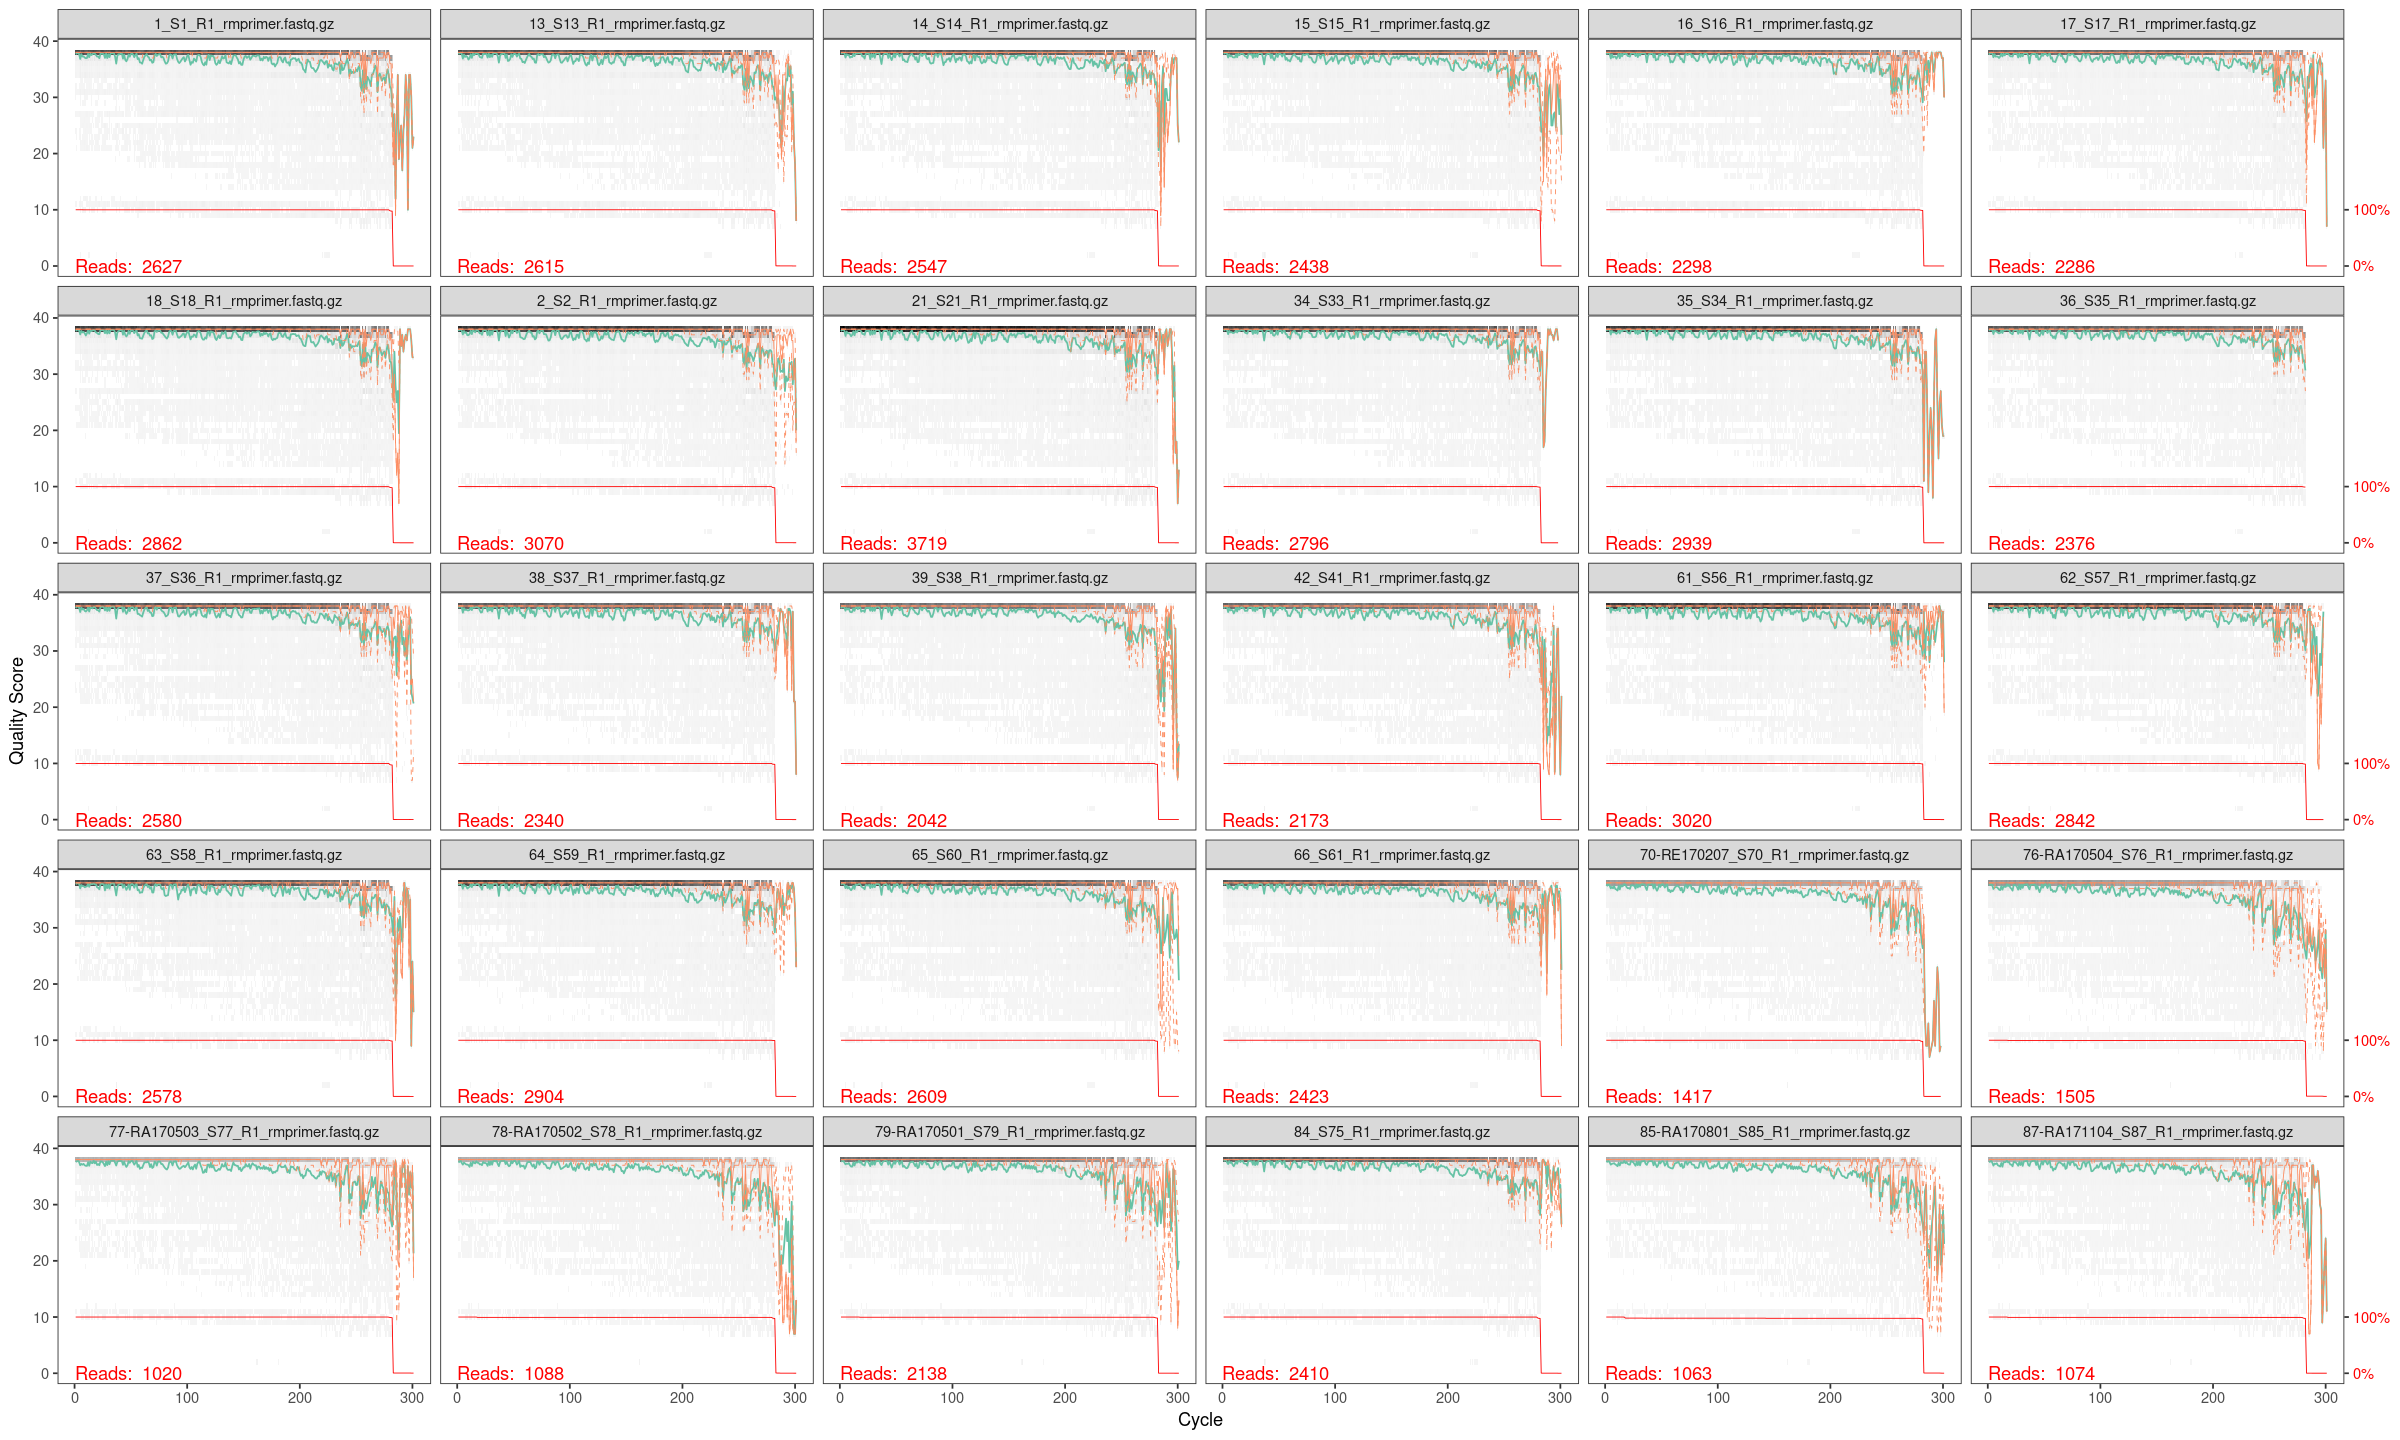

In [32]:
options(repr.plot.width=20, repr.plot.height=12)
quality_plot_R1

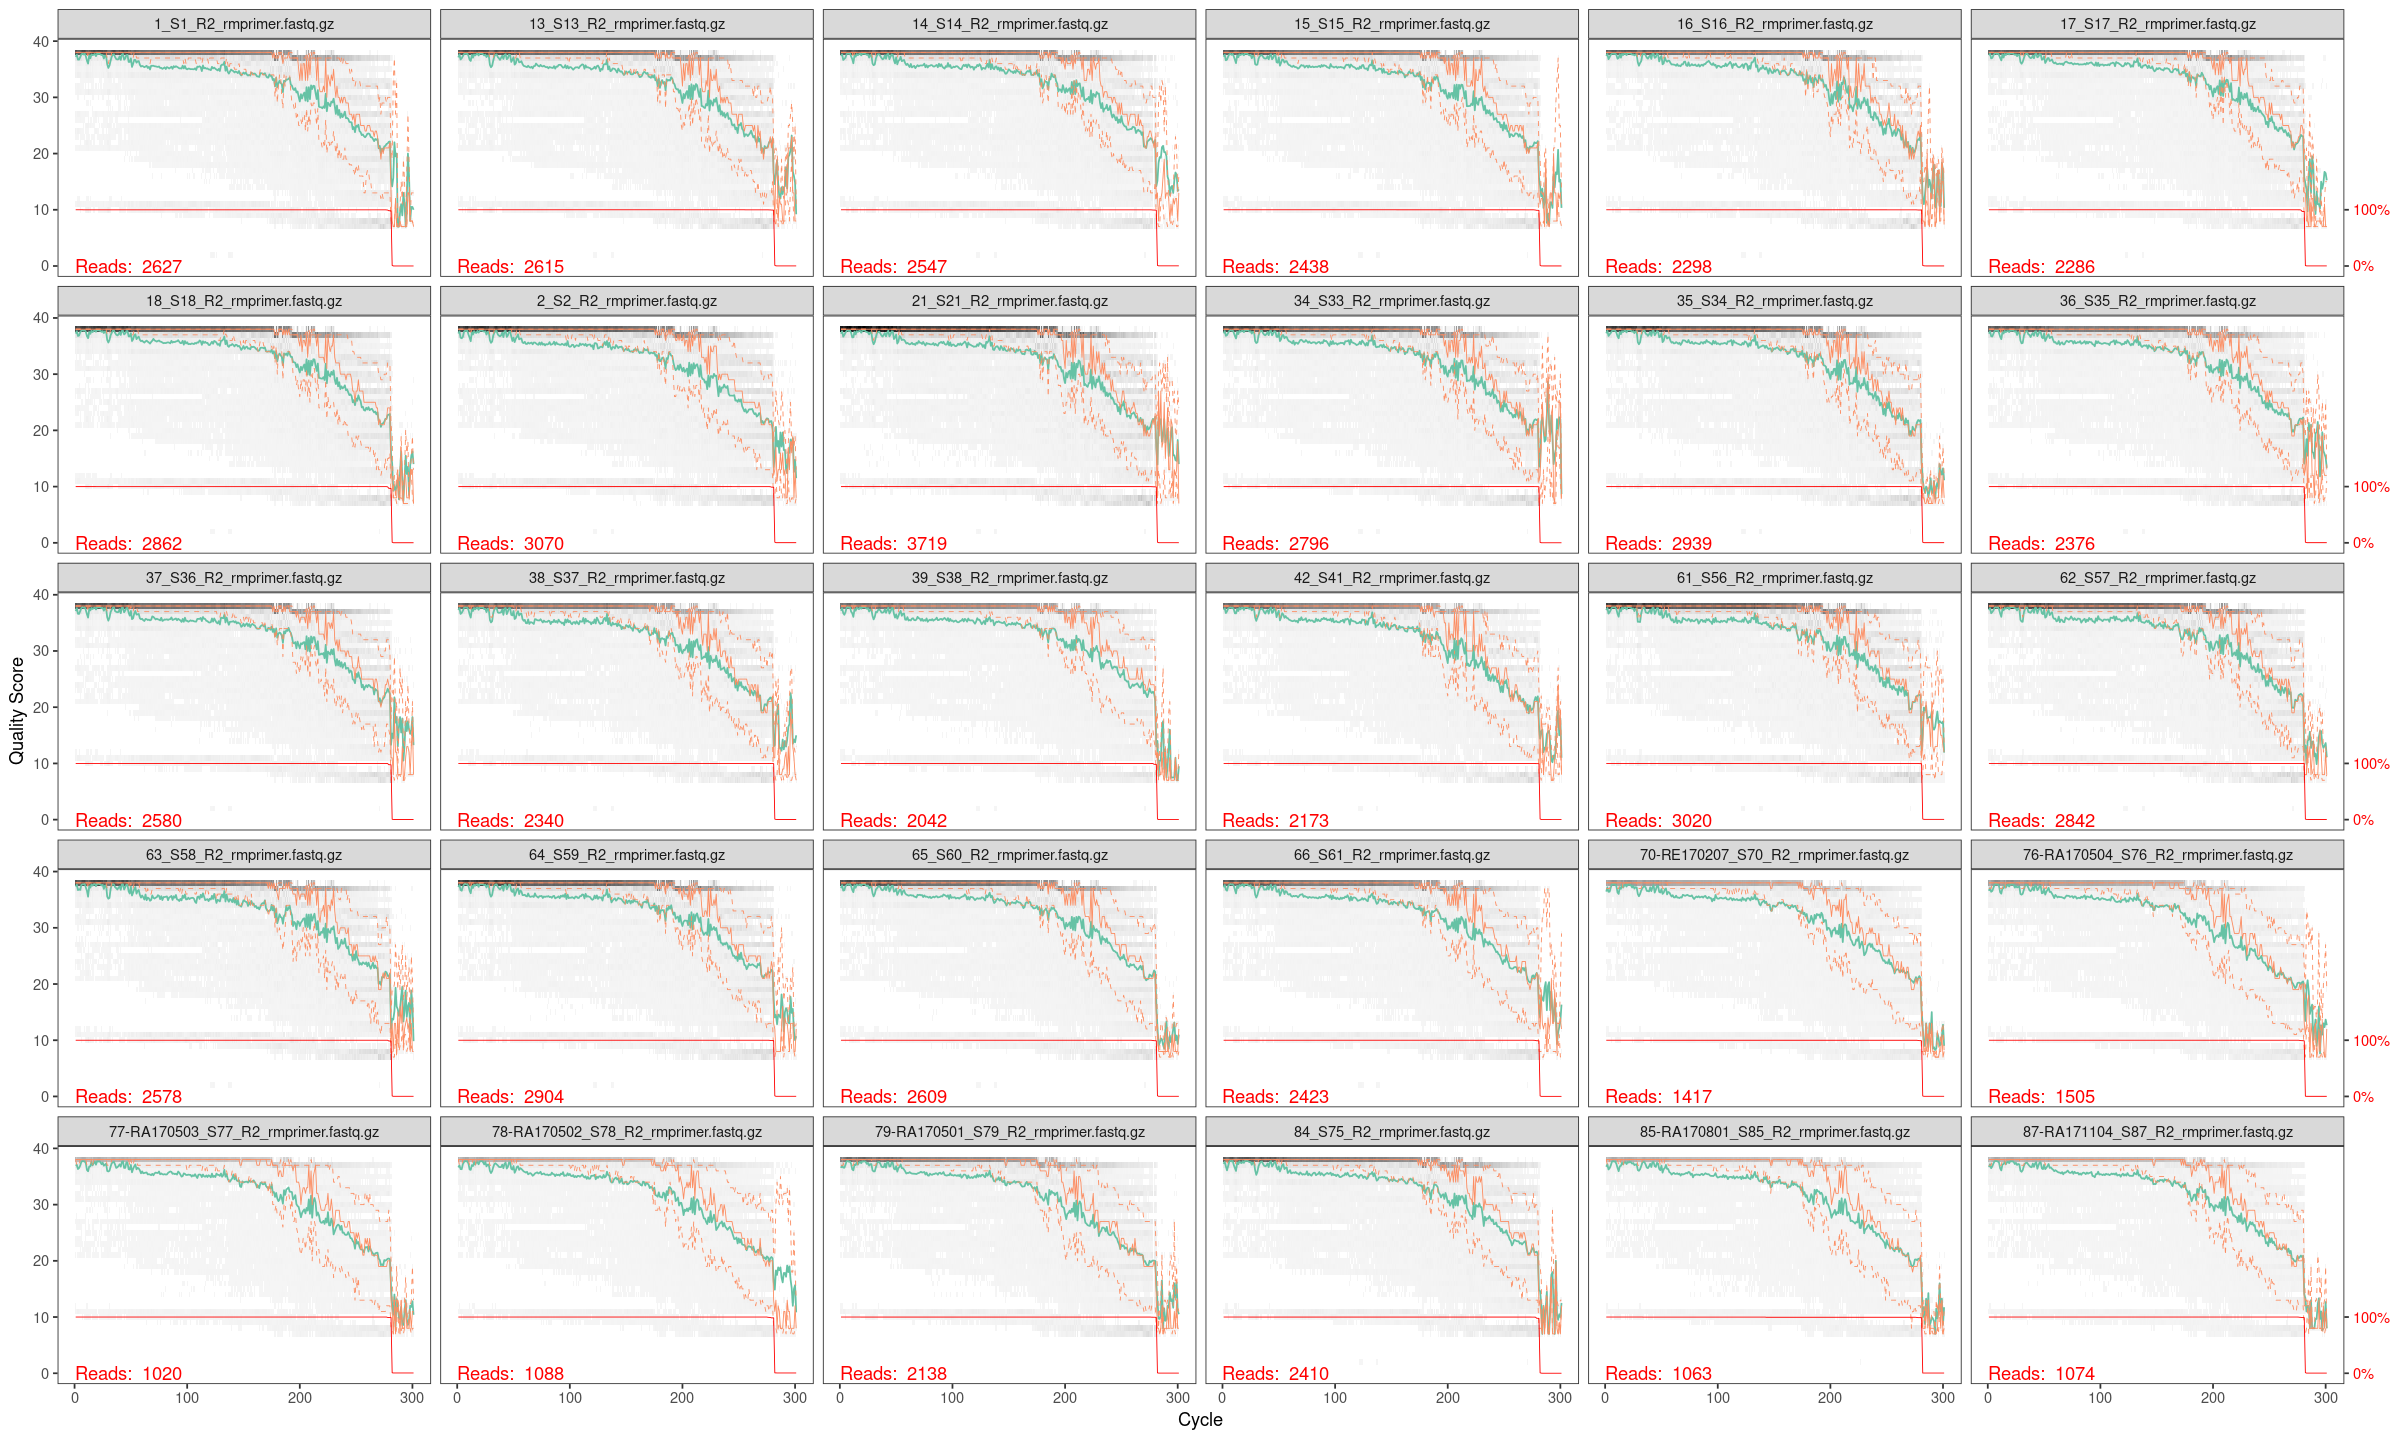

In [33]:
options(repr.plot.width=20, repr.plot.height=12)
quality_plot_R2

Estos plots muestran la distribución de los puntajes de calidad en cada posición (mapa de calor de gris a negro).   
Las línea verde es la media, el naranja es la mediana y las líneas naranjas discontinuas corresponden al primer y tercer cuartil.

Como sucede generalmente, observamos que la calidad de las secuencias decrece a lo largo de los _reads_ y hay un diferencia notoria entre la calidad de los _reads_ R1 y R2.  
¿Sabes por qué es esto? [Acá puedes encontrar una respuesta](https://www.ecseq.com/support/ngs/why-has-reverse-read-a-worse-quality-than-forward-read-in-Illumina-sequencing).

---
### Comienza sección <img src="../figures/uphill.png" width="50" height="50" />
---

Ahora vamos a realizar un análisis de calidad que puede resultar muy útil para identificar muestras problemáticas.  
Lo que vamos a hacer es comparar, para cada muestra, la calidad promedio (de una submuestra) de _reads_ vs. el número de _reads_.

Primero vamos a contar el número _reads_ con la función que definimos arriba `count_seqs` y para hacerlo más rápido, utilizaremos las facilidades de `doParallel` (i.e., [foreach with %dopar%](https://cran.r-project.org/web/packages/doParallel/vignettes/gettingstartedParallel.pdf)).

In [34]:
seq_counts_df <- foreach(i = rmprimerR1, .combine=rbind) %dopar% {
  count_seqs(i)
}

Luego, computamos los promedios de calidad de R1. Para esto utilizamos la función [qa](https://rdrr.io/bioc/ShortRead/man/qa.html) de ShortRead.  
Para correr esta función, similarmente a cómo lo hicimos arriba, debemos especificar un directorio de entrada y un patrón para identificar los archivos que vamos a analizar.

In [35]:
INPUT_DIR <- "./data/rm_primers"

In [36]:
PATTERN_R1 <- "_R1_rmprimer.fastq.gz" 

In [37]:
qa_r1 <- qa(dirPath = INPUT_DIR, pattern = PATTERN_R1, sample = T, n = 5000)
qa_r1_df <- qa_r1[["perCycle"]][["quality"]]
qa_means_r1 <- qa_r1_df %>%
               group_by(lane) %>%
               summarize(mean_q = sum(Score*Count)/sum(Count))
qa_means_r1$lane <- qa_means_r1$lane %>% sub(x = ., pattern = "_R1.*", replacement = "")

Y también para R2.

In [38]:
PATTERN_R2 <- "_R2_rmprimer.fastq.gz" 

In [39]:
qa_r2 <- qa(dirPath = INPUT_DIR, pattern = PATTERN_R2, sample = T, n = 5000)
qa_r2_df <- qa_r2[["perCycle"]][["quality"]]
qa_means_r2 <- qa_r2_df %>%
               group_by(lane) %>%
               summarize(mean_q = sum(Score*Count)/sum(Count))
qa_means_r2$lane <- qa_means_r2$lane %>% sub(x = ., pattern = "_R2.*", replacement = "")

Siguiente paso es cruzar los resultados de promedios de calidad con el número de secuencias por muestra, lo que podemos hacer fácilmente con la función [left_join](https://dplyr.tidyverse.org/reference/mutate-joins.html) de `tidyverse`. 

In [40]:
qa_means1counts <- left_join(x = qa_means_r1, y = seq_counts_df, by = c("lane" = "sample"))
qa_means2counts <- left_join(x = qa_means_r2, y = seq_counts_df, by = c("lane" = "sample"))

Finalmente, realizamos los plots para R1 y R2.

In [41]:
qual_vs_nseq_r1 <- ggplot(data = qa_means1counts, aes(x = mean_q, y = nseq)) +
  geom_point(size = 3) +
  theme_bw() +
  #scale_y_log10() +
  ylab("Read counts (log)") +
  xlab("Mean quality score (R1)") +
  geom_text(aes(label=as.character(lane)), hjust=0.5, vjust=-1, size = 5)

In [42]:
qual_vs_nseq_r2 <- ggplot(data = qa_means2counts, aes(x = mean_q, y = nseq)) +
  geom_point(size = 3) +
  theme_bw() +
  #scale_y_log10() +
  ylab("Read counts (log)") +
  xlab("Mean quality score (R1)") +
  geom_text(aes(label=as.character(lane)), hjust=0.5, vjust=-1, size = 5)

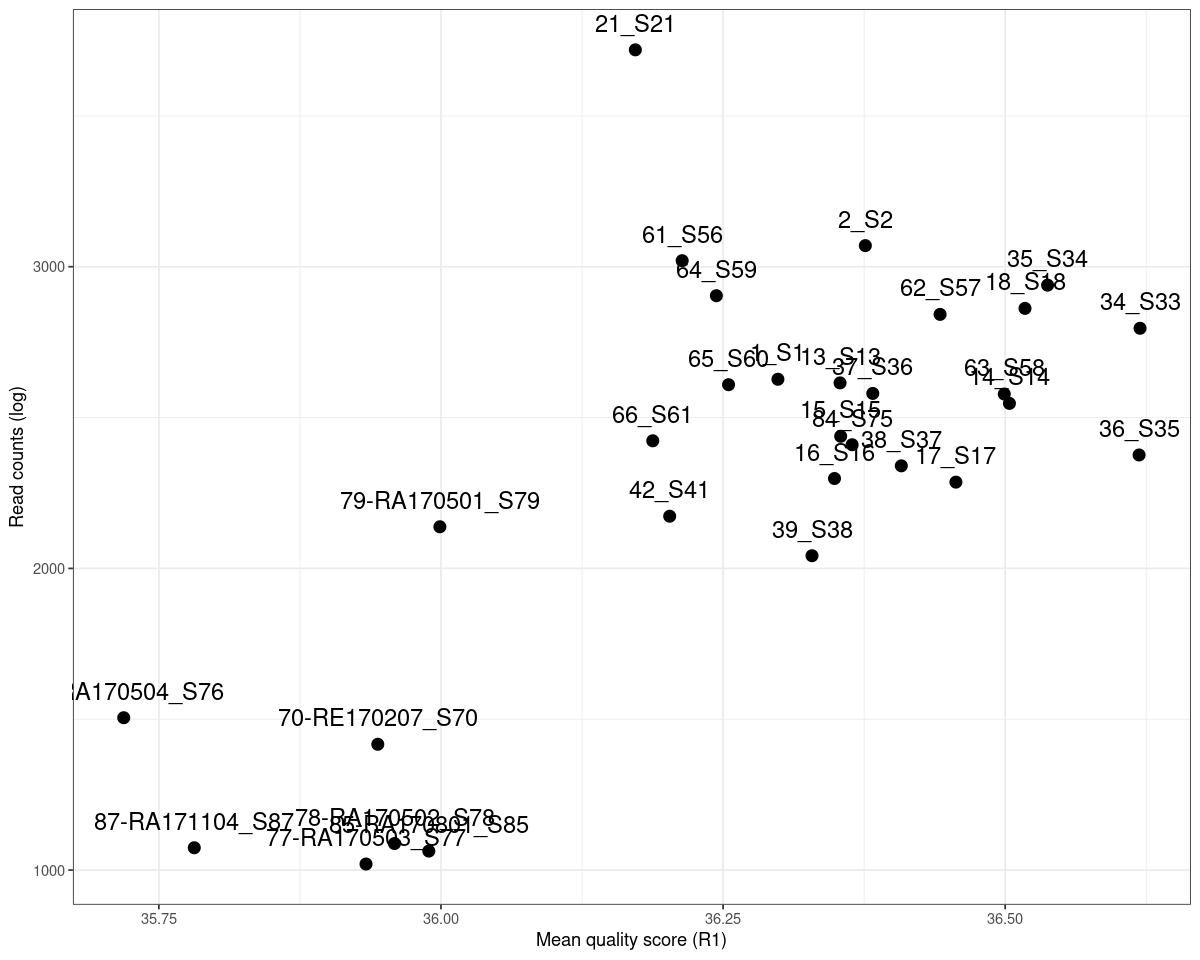

In [43]:
options(repr.plot.width=10, repr.plot.height=8)
qual_vs_nseq_r1

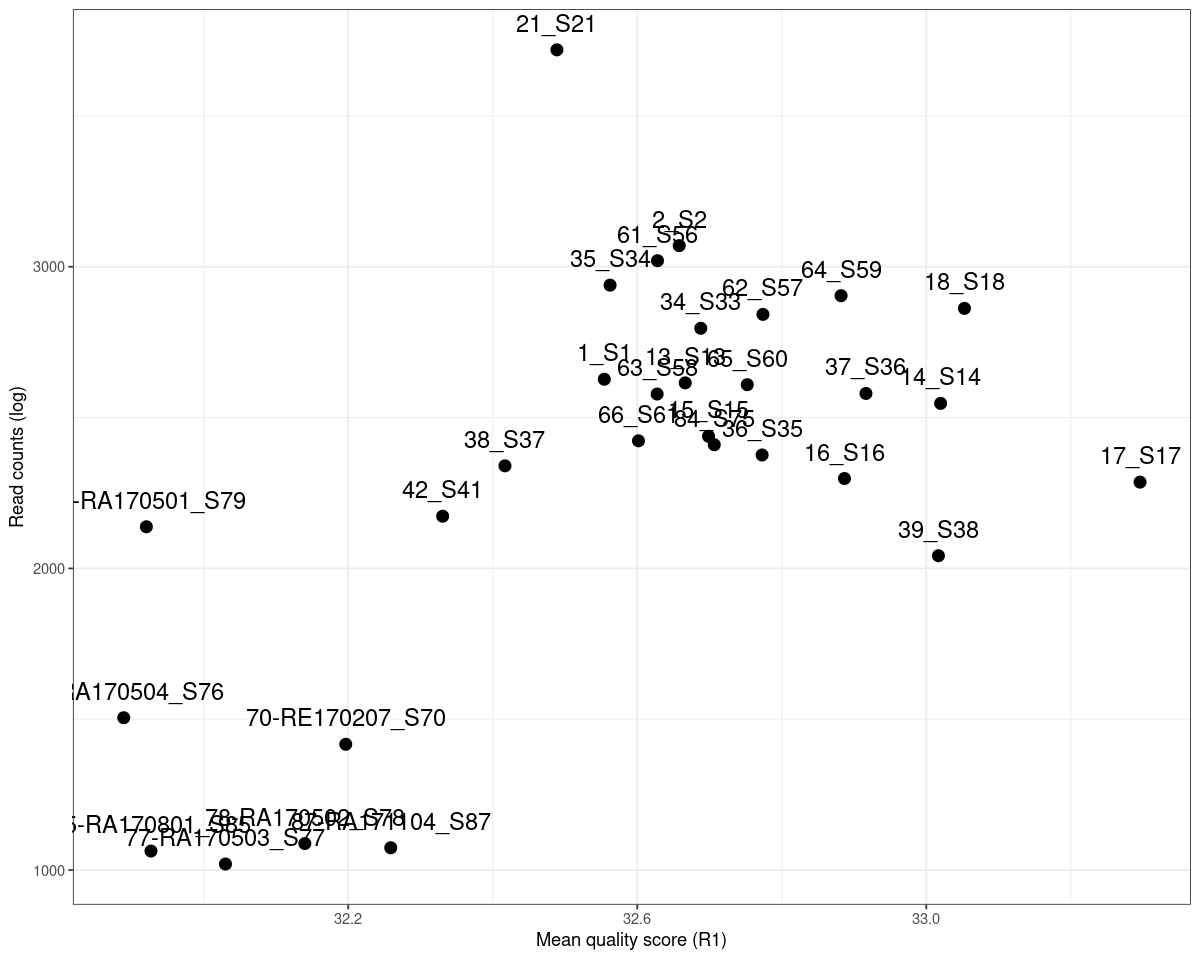

In [44]:
options(repr.plot.width=10, repr.plot.height=8)
qual_vs_nseq_r2

Es interesante que parecen formarse dos grupos: uno de mayor calidad y mayor número de secuencias, y otro de menor calidad y menor número de secuencias.  
Este plot puede ser un insumo para definir si es necesario descartar algunas muestras.  
En nuestro caso, el grupo de menor calidad aún es suficientemente bueno (tenemos puntajes por arriba de 32 y un número de _reads_ comparable). En consecuencia, no estaremos descartando ninguna muestra.

---
### Fin de sección <img src="../figures/uphill.png" width="50" height="50" />
---

Como última tarea en el control de calidad, vamos a recortar las regiones 5' de los _reads_. Para esto, en base a los plots `quality_plot_R1` y `quality_plot_R2` vamos a definir el punto de corte. Esta decisión es algo subjetiva, y es conveniente probar qué resultados obtenemos con distintos valores. En este práctico, a los efectos de mostrar cómo funciona esta función, estaremos utilizando dos únicos valores, uno para los _reads_ R1 y otro para los R2.

In [45]:
TRUNC_R1 <- 250
TRUNC_R2 <- 225

Al igual a cómo lo hicimos anteriormente, vamos a definir el directorio y nombre de los archivos de salida, ya que queremos que estos archivos filtrados por la calidad queden guardados en nuestra computadora.

In [46]:
OUTPUT_DIR <- "./data/quality_filtered"
dir.create(OUTPUT_DIR)

Warning message in dir.create(OUTPUT_DIR):
“'./data/quality_filtered' already exists”


In [47]:
filtR1 <- file.path(OUTPUT_DIR, paste(sample.names, "R1_filt.fastq.gz", sep = "_"))
filtR2 <- file.path(OUTPUT_DIR, paste(sample.names, "R2_filt.fastq.gz", sep = "_"))

In [48]:
filterAndTrim_log <- filterAndTrim(fwd = rmprimerR1, filt = filtR1, 
                                   rev = rmprimerR2, filt.rev = filtR2, 
                                   truncLen = c(TRUNC_R1, TRUNC_R2),
                                   maxN = 0, maxEE = c(2,2), truncQ = 2, rm.phix = TRUE,
                                   compress=TRUE, 
                                   multithread = 4)

Puedes consultar la ayuda de la función `filterAndTrim` para ver qué significan estos parámetros.

Veamos la salida de esta función.

In [49]:
list.files(OUTPUT_DIR)

[1] "1_S1_R1_filt.fastq.gz"            "1_S1_R2_filt.fastq.gz"           
 [3] "13_S13_R1_filt.fastq.gz"          "13_S13_R2_filt.fastq.gz"         
 [5] "14_S14_R1_filt.fastq.gz"          "14_S14_R2_filt.fastq.gz"         
 [7] "15_S15_R1_filt.fastq.gz"          "15_S15_R2_filt.fastq.gz"         
 [9] "16_S16_R1_filt.fastq.gz"          "16_S16_R2_filt.fastq.gz"         
[11] "17_S17_R1_filt.fastq.gz"          "17_S17_R2_filt.fastq.gz"         
[13] "18_S18_R1_filt.fastq.gz"          "18_S18_R2_filt.fastq.gz"         
[15] "2_S2_R1_filt.fastq.gz"            "2_S2_R2_filt.fastq.gz"           
[17] "21_S21_R1_filt.fastq.gz"          "21_S21_R2_filt.fastq.gz"         
[19] "34_S33_R1_filt.fastq.gz"          "34_S33_R2_filt.fastq.gz"         
[21] "35_S34_R1_filt.fastq.gz"          "35_S34_R2_filt.fastq.gz"         
[23] "36_S35_R1_filt.fastq.gz"          "36_S35_R2_filt.fastq.gz"         
[25] "37_S36_R1_filt.fastq.gz"          "37_S36_R2_filt.fastq.gz"         
[27] "38_S37_R1_filt.fastq.gz"          "38_S37_R2_filt.fastq.gz"         
[29] "39_S38_R1_filt.fastq.gz"          "39_S38_R2_filt.fastq.gz"         
[31] "42_S41_R1_filt.fastq.gz"          "42_S41_R2_filt.fastq.gz"         
[33] "61_S56_R1_filt.fastq.gz"          "61_S56_R2_filt.fastq.gz"         
[35] "62_S57_R1_filt.fastq.gz"          "62_S57_R2_filt.fastq.gz"         
[37] "63_S58_R1_filt.fastq.gz"          "63_S58_R2_filt.fastq.gz"         
[39] "64_S59_R1_filt.fastq.gz"          "64_S59_R2_filt.fastq.gz"         
[41] "65_S60_R1_filt.fastq.gz"          "65_S60_R2_filt.fastq.gz"         
[43] "66_S61_R1_filt.fastq.gz"          "66_S61_R2_filt.fastq.gz"         
[45] "70-RE170207_S70_R1_filt.fastq.gz" "70-RE170207_S70_R2_filt.fastq.gz"
[47] "76-RA170504_S76_R1_filt.fastq.gz" "76-RA170504_S76_R2_filt.fastq.gz"
[49] "77-RA170503_S77_R1_filt.fastq.gz" "77-RA170503_S77_R2_filt.fastq.gz"
[51] "78-RA170502_S78_R1_filt.fastq.gz" "78-RA170502_S78_R2_filt.fastq.gz"
[53] "79-RA170501_S79_R1_filt.fastq.gz" "79-RA170501_S79_R2_filt.fastq.gz"
[55] "84_S75_R1_filt.fastq.gz"          "84_S75_R2_filt.fastq.gz"         
[57] "85-RA170801_S85_R1_filt.fastq.gz" "85-RA170801_S85_R2_filt.fastq.gz"
[59] "87-RA171104_S87_R1_filt.fastq.gz" "87-RA171104_S87_R2_filt.fastq.gz"
[61] "filtered"

Todo parece correcto, pero por mayor control puedes abrir alguno de estos archivos desde la línea de comando en BASH.

---
### 6. Modelado de errores 
---

Como recordarás del teórico, DADA2 realiza una inferencia de ASVs en base al modelado de los errores en los _reads_ para cada puntaje de calidad.

<img src="../figures/dada2_error_fig_and_eq.png" width="800" height="800" />

Esto nos da, por ejemplo, la probabilidad de observar una transición para un puntaje de calidad de 35: p(A→C, 35).

El 3x y 4x que aparecen arriba de los _reads_ representan su abundancia.

Para modelar los errores, DADA2 cuenta con la función [learnErros](https://rdrr.io/bioc/dada2/man/learnErrors.html), la cual estarmos utilizando luego de cargar los datos.  
Notar que ahora vamos a trabajar con los archivos sin _primers_ y filtrados por calidad, los cuales tenemos en los vectores `filtR1` y `filtR2`.

In [50]:
errR1 <- learnErrors(filtR1, multithread=4)
errR2 <- learnErrors(filtR2, multithread=4)

13700500 total bases in 54802 reads from 30 samples will be used for learning the error rates.
12330450 total bases in 54802 reads from 30 samples will be used for learning the error rates.


Muy convenientemente, DADA2, incluye una función para visualizar el modelado de errores: [plotErrors](https://rdrr.io/bioc/dada2/man/plotErrors.html).

In [51]:
error_plot_R1 <- plotErrors(errR1, nominalQ=TRUE)
error_plot_R2 <- plotErrors(errR2, nominalQ=TRUE)

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


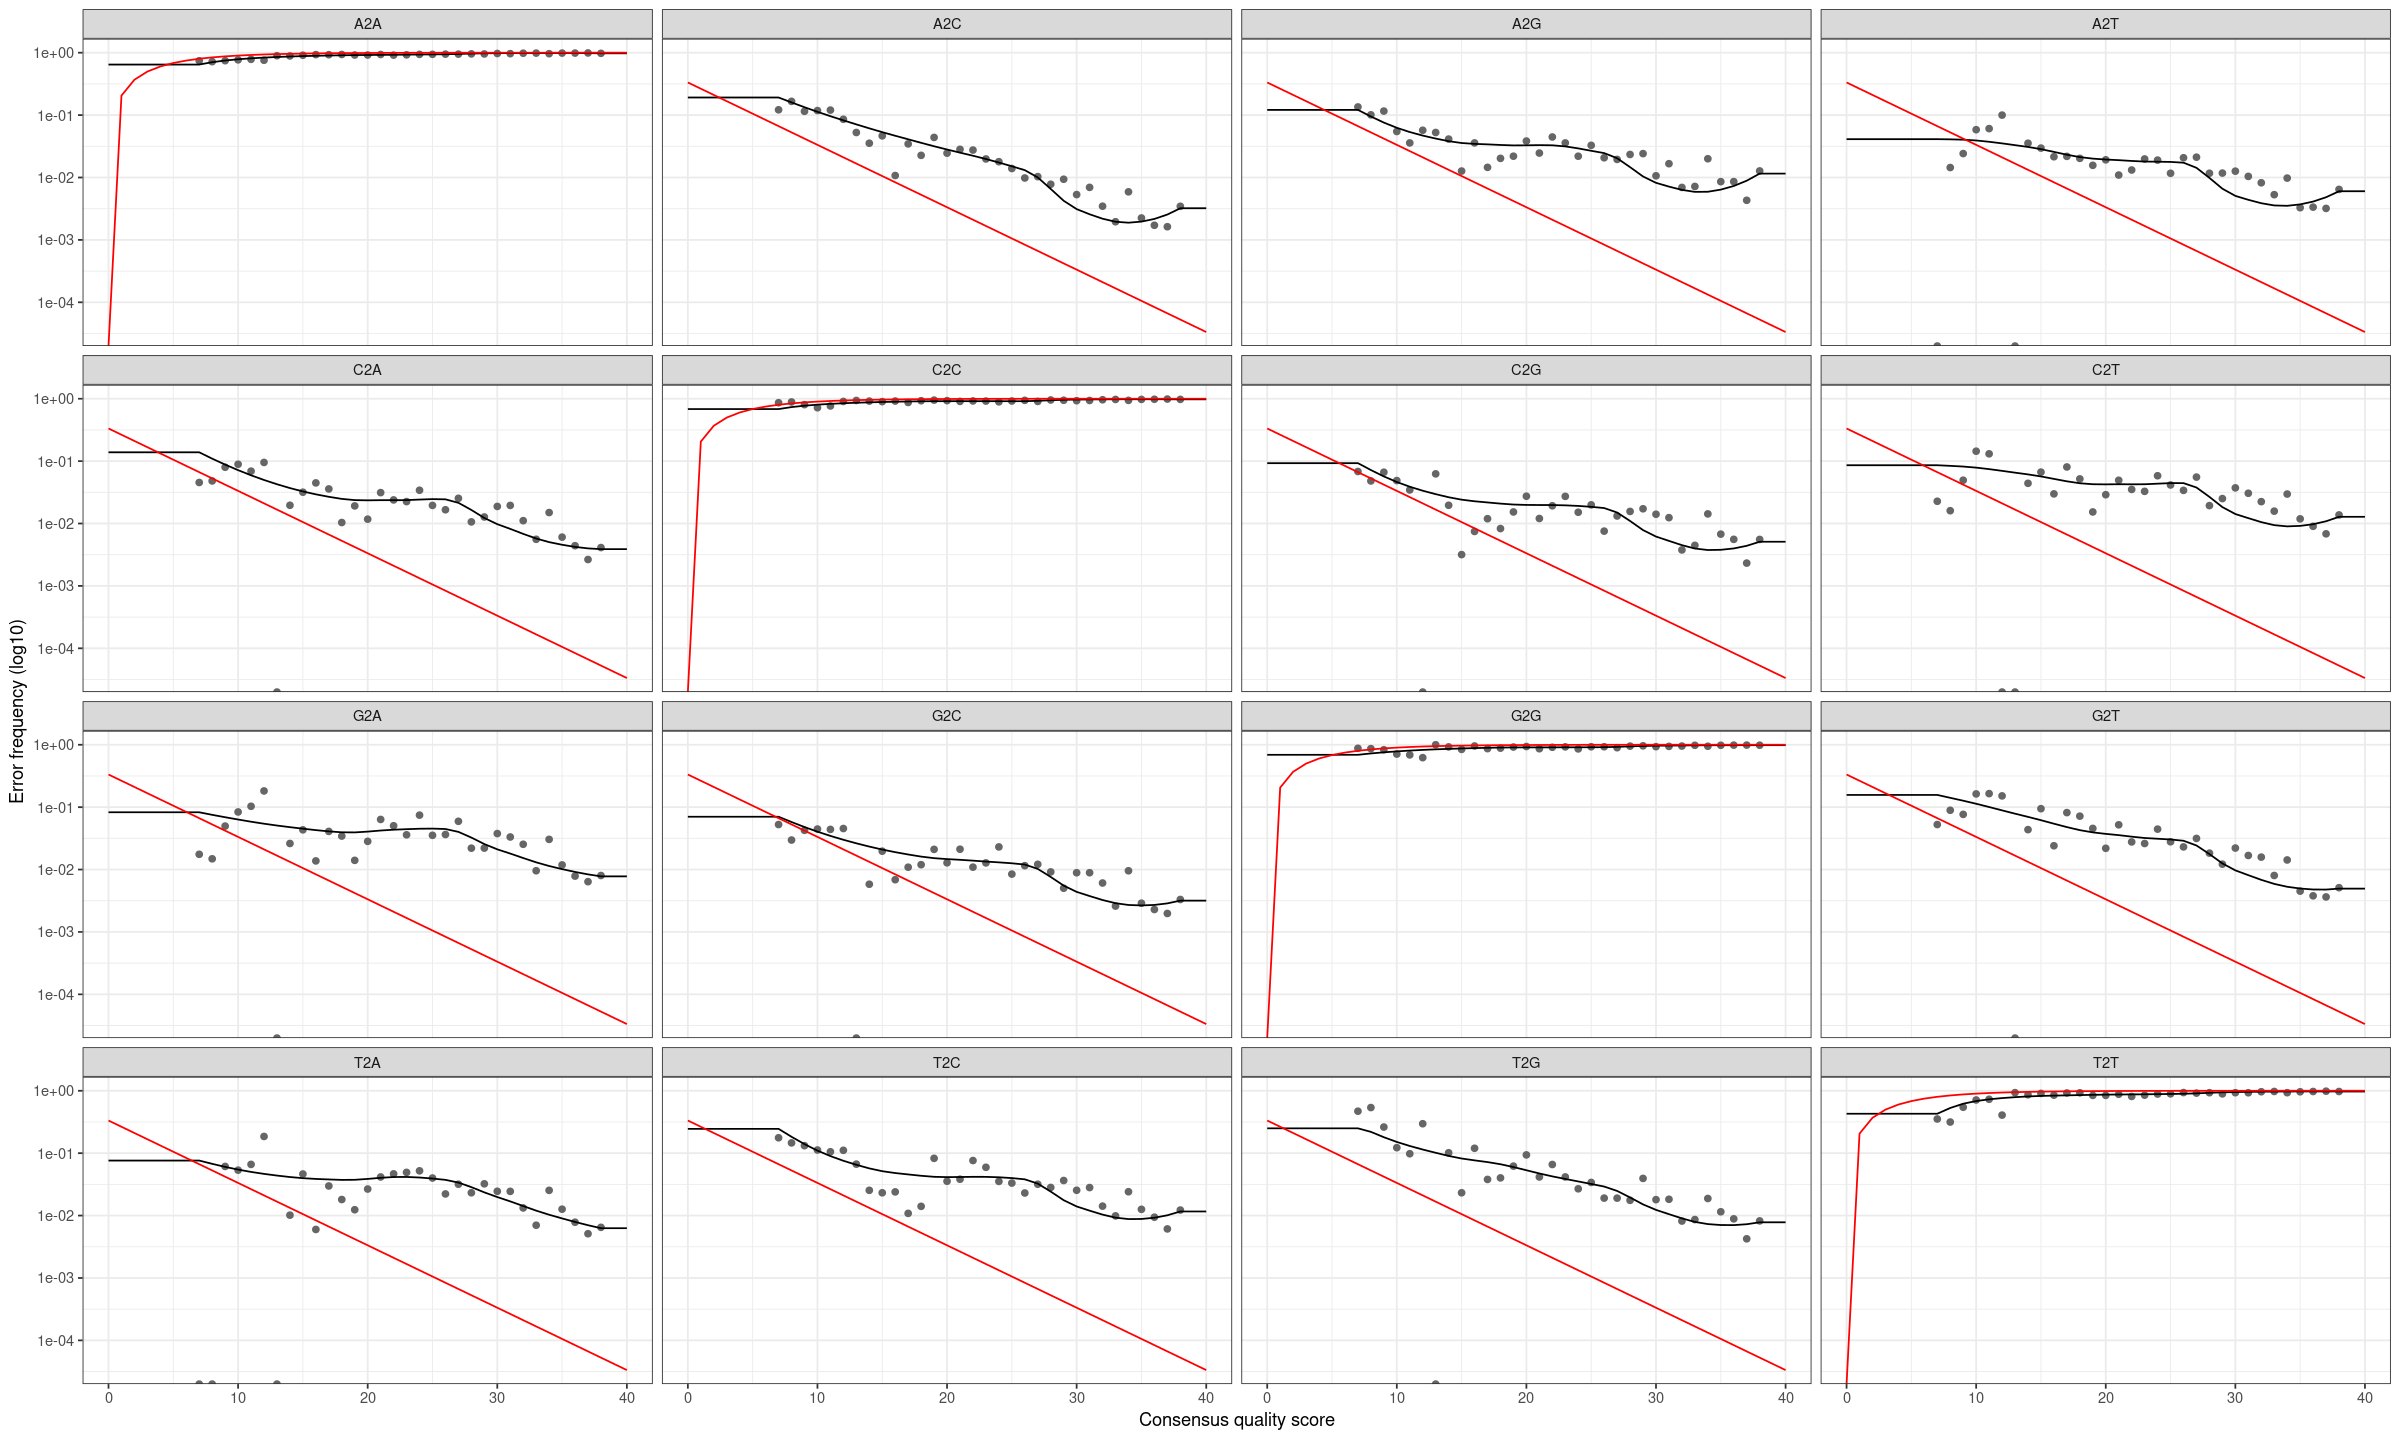

In [52]:
options(repr.plot.width=20, repr.plot.height=12)
error_plot_R1

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


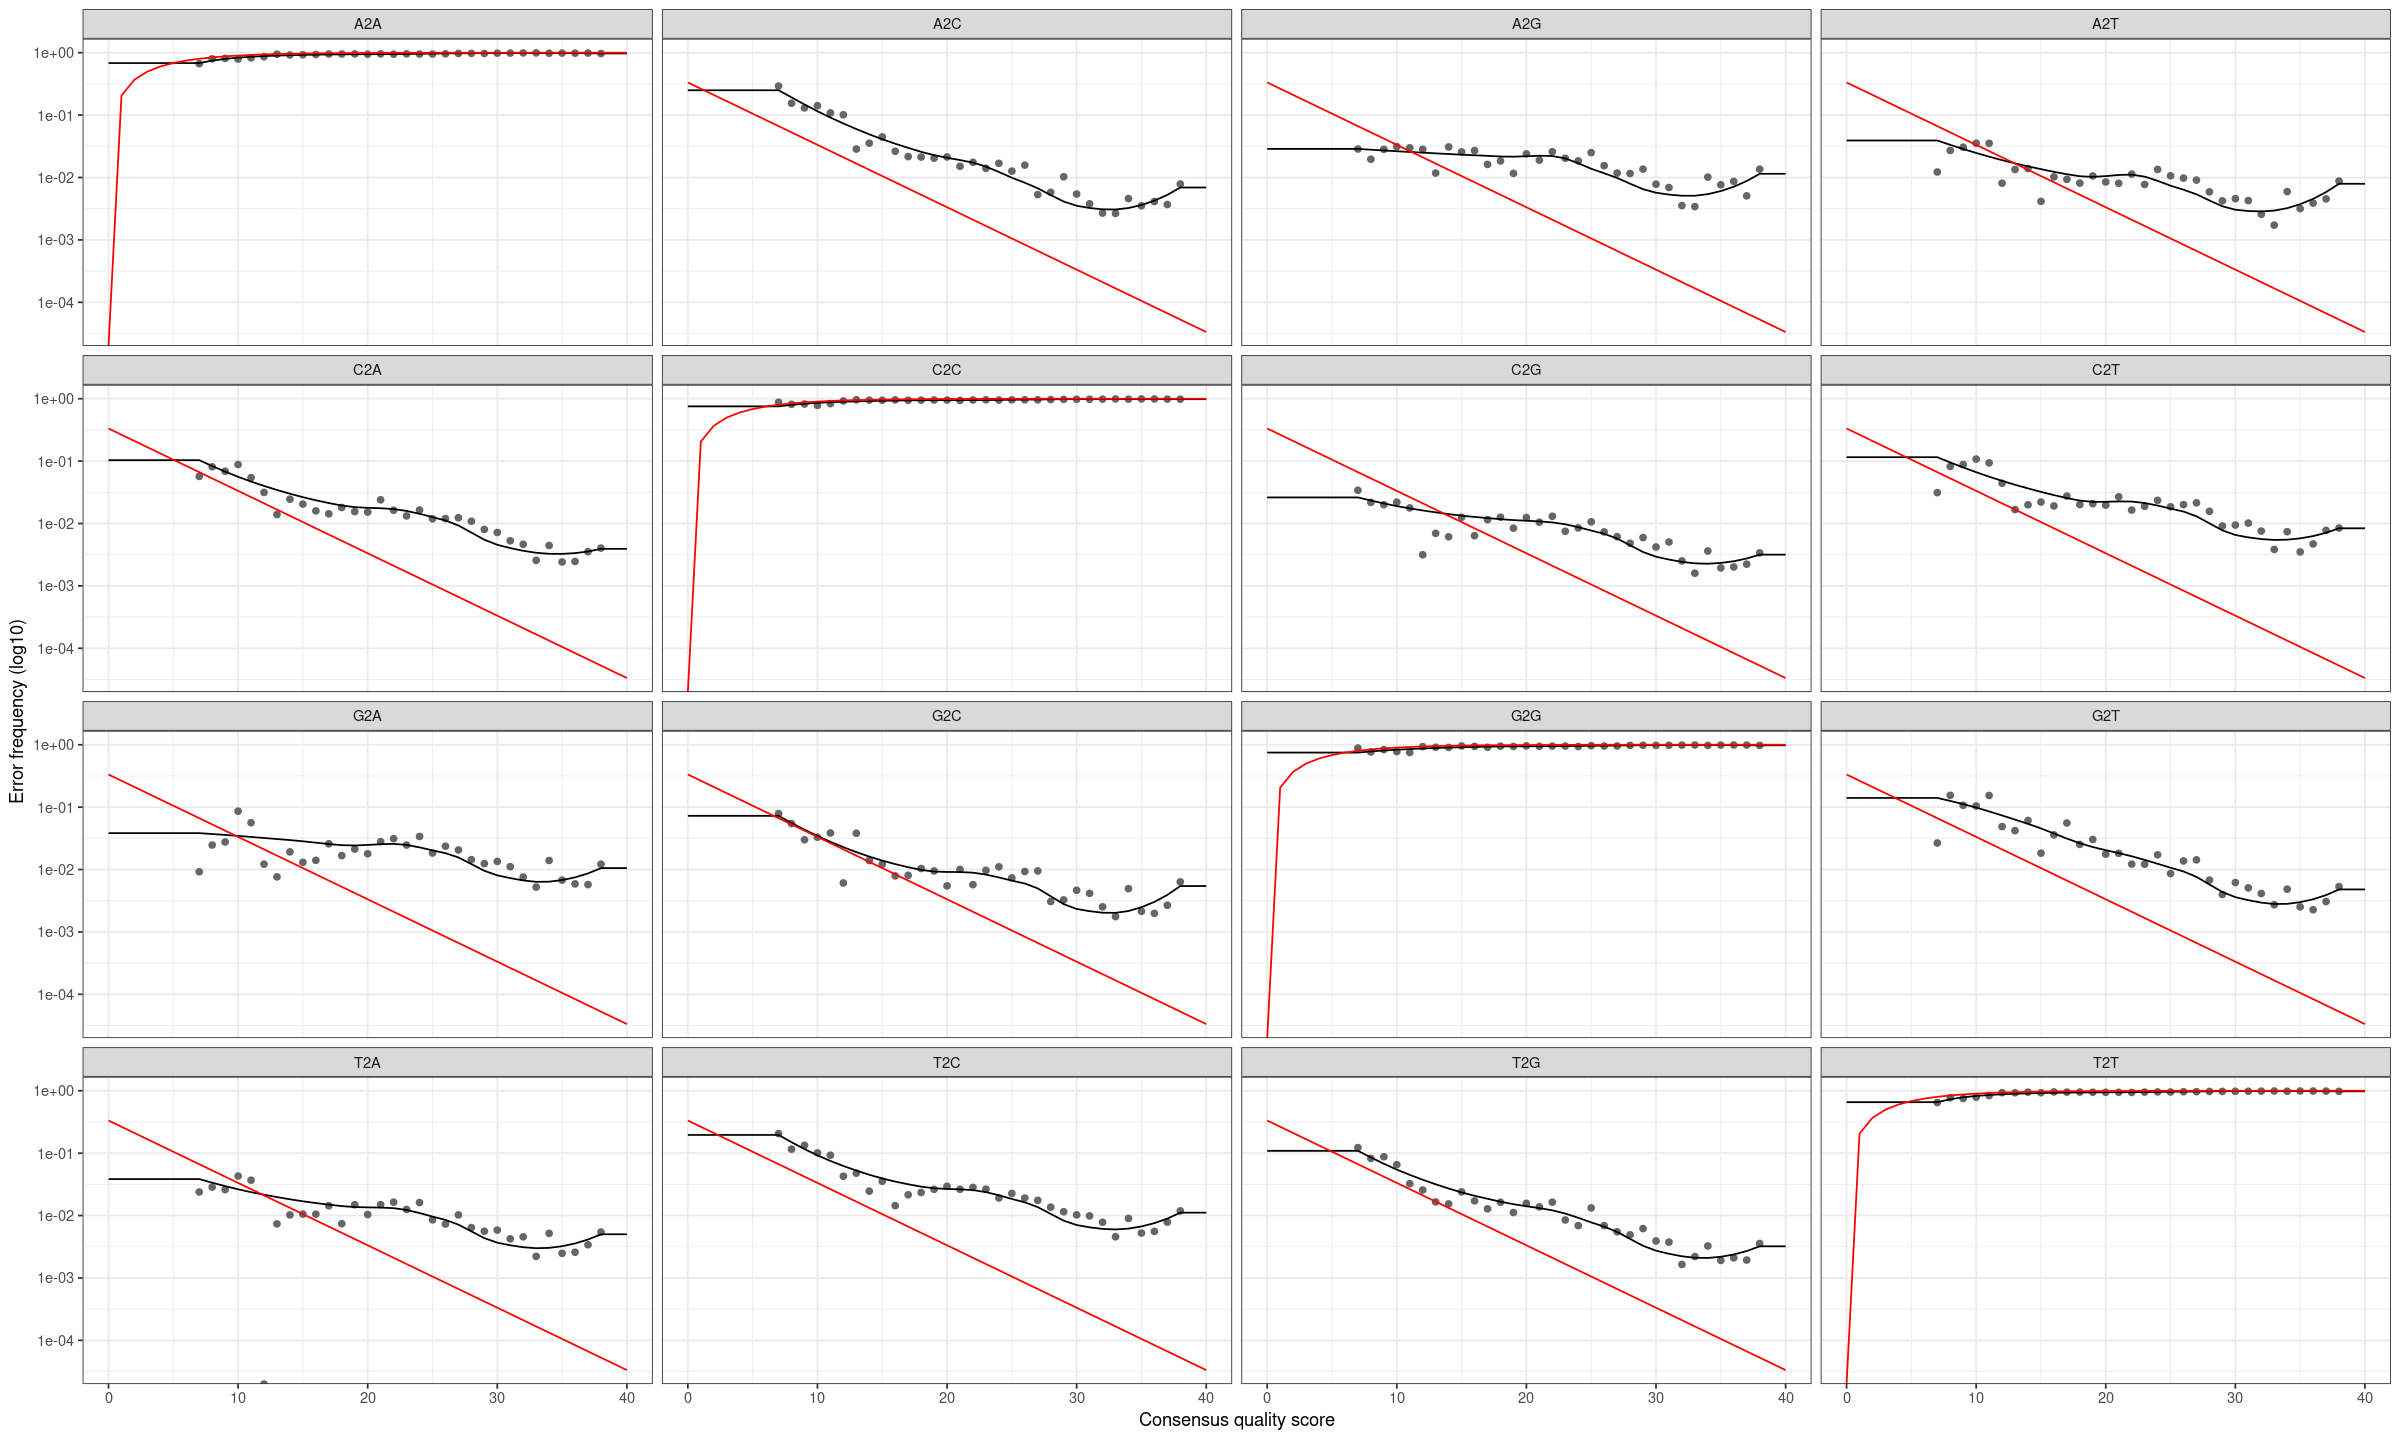

In [53]:
options(repr.plot.width=20, repr.plot.height=12)
error_plot_R2

"El eje x muestra el nivel de calidad; el eje y la frecuencia de la transición. Los puntos muestran las frecuencias observadas, la línea negra el modelo de error inferido por DADA2 utilizando su ajuste loess y la línea roja las tasas esperadas dada la definición nominal del puntaje de calidad. Las puntuaciones de calidad de Illumina son bastante informativas sobre las tasas de error de sustitución, pero se observan desviaciones sistemáticas de las tasas esperadas". Texto traducido de [(Callahan et al 2016)](https://www.nature.com/articles/nmeth.3869).

---
### 7. Derreplicado
---

Este paso, consiste simplemente en agrupar todas las secuencias que aparecen idénticas en nuestros datos, sin utilizar ningún modelado de errores.
Como resultado, todas las secuencias iguales son agrupadas en una única secuencia, para la cual además es registrada su abundancia, como se muestra en la figura de abajo.

<img src="../figures/dada2_dereplicado.png" width="500" height="500" />

Para esto simplemente corremos dos comandos utilizando la función  [derepFastq](https://www.rdocumentation.org/packages/dada2/versions/1.0.3/topics/derepFastq).

In [54]:
derepR1 <- derepFastq(filtR1)
derepR2 <- derepFastq(filtR2)

---
### 8. Identificación de ASVs
---

Está parte es, probablemente, la más fundamental en todo el flujo de trabajo: la reconstrucción de ASVs mediante el _Divisive partitioning algorithm_.

<img src="../figures/dada2_iter.png" width="700" height="700" />

Donde el p-valor A entre los _reads_ "i" y "j" se computa cómo:

<img src="../figures/p_valorA_formula.png" width="300" height="300" />

Y "nj" y "ai" son las abundancias de las secuencias "j" e "i", respectivamente.

Vayamos al grano.

In [55]:
dadaR1 <- dada(derepR1, err=errR1, multithread=4, pool = T)
dadaR2 <- dada(derepR2, err=errR2, multithread=4, pool = T)

30 samples were pooled: 54802 reads in 14086 unique sequences.
30 samples were pooled: 54802 reads in 16292 unique sequences.


¿Qué utilidad tiene la opción `pool`?

---
### 9. Ensamblado de secuencias pares
---

Esta tarea consiste en alinear los extremos de los _reads_ R1 y R2 para unir las secuencias en el caso de que exista una superposición mayor a `minOverlap`.  
Dado que los ASVs ya fueron identificados para R1 y R2, el alineamiento debe de ser exacto (sin _mismatches_ o _gaps_). En este práctico estaremos utilizando un único valor de `minOverlap`; no obstante, si estuviéramos trabajando con datos que no conocemos, sería conveniente probar distintos valores de `minOverlap` y evaluar cómo se ve afectado el _merging_ en cada caso. Notar que para definir este parámetro, también debemos tener en cuenta cuánto hemos recortado los _reads_ en el control de calidad.

En nuestro caso, usaremos un `minOverlap` de 12 bases. 

In [56]:
MIN_OVERLAP <- 12

In [57]:
merged <- mergePairs(dadaR1, derepR1, 
                      dadaR2, derepR2,
                      minOverlap = MIN_OVERLAP)

---
### 10. Creación de la matriz de abundancias
---

El objeto `merged` tiene toda la información que precisamos, pero no es un formato muy amigable. Por este motivo, y para realizar la eliminación de bimeras, vamos a convertir el objeto `merged` en una tabla.

In [58]:
seqtab <- makeSequenceTable(merged)

Veamos qué dimensiones tiene la tabla de abundancias.

In [59]:
dim(seqtab2)

ERROR: Error in eval(expr, envir, enclos): object 'seqtab2' not found


Esto es, 30 muestras (filas) por 1240 ASVs (columnas). Este es un número bajo de ASVs, pero debemos tener en cuenta que estamos trabajando con un set de datos de "juguete".

Veamos algunas filas y columnas de nuestra matriz.

In [ ]:
seqtab[1:3, 1:3]

Se ve un poco raro, dado que los nombres de las columnas son las secuencias de cada ASV. No obstante, resultará muy conveniente tener estas secuencias en posteriores análisis.

---
### 11. Eliminación de bimeras
---

La última parte en el análisis de identificación de ASVs, consiste en eliminar las bimeras. Estas se forman durante la amplifcación por PCR como se explica [acá](https://drive5.com/usearch/manual8.1/chimera_formation.html).

Aunque podriamos utilizar otras herramientas, por ejemplo [vsearch](https://github.com/torognes/vsearch), resulta especialmente conveiente seguir trabjando en R con DADA2, por lo que utilizaremos la función [removeBimeraDenovo](https://rdrr.io/bioc/dada2/man/removeBimeraDenovo.html). Esto se debe no sólo al hecho de que es necesario realizar menos pasos en la manipulación de datos, sino también a que `removeBimeraDenovo`, al trabajar sobre ASVs, es particularmente sensible.  
"Los algoritmos comunes de identificación de quimeras fueron diseñados bajo el supuesto de que la sensibilidad en las variantes quiméricas cercanas no era muy importante porque las variantes cercanas probablemente se clusterizarán en una misma OTU de todos modos. Sin embargo, DADA2 viola esta suposición, ya que distingue variantes que difieren tan solo en un nucleótido." Texto traducido de [(Callahan et al 2016)](https://www.nature.com/articles/nmeth.3869).

In [ ]:
seqtab.nochim <- removeBimeraDenovo(seqtab, multithread = 4)

Veamos cuantos ASVs quedaron luego de la eliminación de bimeras.

In [ ]:
dim(seqtab.nochim)

Con el siguiente comando podemos computar el porcentaje que fue eliminado:

In [ ]:
100 -(100*dim(seqtab.nochim)[2]/dim(seqtab)[2]) |> round(3)

15.565% es un porcentaje bastante razonable. Comúnmente se observan valores más altos.

Esta tabla es nuestro resultado final en la identificación de ASVs, por lo que vamos a guardarla en formato csv.

In [ ]:
OUTPUT_DIR <- "./results"
dir.create(OUTPUT_DIR)
write.csv(x = t(seqtab.nochim), file = file.path(OUTPUT_DIR, "asv_abund.csv"))

---
### 12. Rastreo de secuencias
---

---
### Comienza sección <img src="../figures/uphill.png" width="50" height="50" />
---

En esta tarea vamos a contar el número de secuencias en las distintas etapas del preprocesamiento, identificación de ASVs y eliminación de bimeras.

In [ ]:
track_n_seqs <- data.frame(samples = sample.names,
                           raw = filterAndTrim_log[,1],
                           filtered = filterAndTrim_log[,2],
                           denoisedR1 = sapply(dadaR1, getUniques) %>% sapply(., sum),
                           denoisedR2 = sapply(dadaR2, getUniques) %>% sapply(., sum), 
                           merged = sapply(mergers, getUniques) %>% sapply(., sum),
                           nobim = rowSums(seqtab.nochim),
                           stringsAsFactors = F)

In [ ]:
head(track_n_seqs) 

Pasamos a formato largo.

In [ ]:
track_n_seqs_long <- track_n_seqs %>%
                     pivot_longer(names_to = "var", 
                                  values_to = "value", 
                                  raw:nobim)

Ordenamos los nombres de las variables de acuerdo al procesamiento de los datos.

In [ ]:
track_n_seqs_long$var <- factor(track_n_seqs_long$var, 
                                levels = c("raw","filtered", "denoisedR1", 
                                           "denoisedR2", "merged","nobim"))

Creamos la visualización.

In [ ]:
nseq_barplots <- ggplot(track_n_seqs_long, aes(x = var, y = value)) +
                 facet_wrap(~ samples, ncol = 6, scales = "free") +
                 geom_bar(stat = "identity", fill = "gray50", alpha = 0.7) +
                 ylab("Number of seqs") +
                 theme_light() +
                 theme(strip.background = element_blank(),
                       strip.text = element_text(color = "black", face = "bold"),
                       axis.text.x = element_text(angle = 45, hjust = 1),
                       axis.title.x = element_blank())

In [ ]:
options(repr.plot.width=20, repr.plot.height=12)
nseq_barplots

---
### Fin de sección <img src="../figures/uphill.png" width="50" height="50" />
---

---
### 13. Anotación taxonómica
---

Por último, estaremos realizando la anotación taxonómica de los ASVs. Nuevamente, existen varias herramientas que realizan esta tarea, cada una planteando sus argumentos a favor.
En esta flujo de trabajo, con la finalidad de seguir trabajando en R, vamos a utilizar la función de DADA2 dedicada a la anotación taxonómica, la cual implementa el _Naive Bayes Classifier_: [assignTaxonomy](https://rdrr.io/bioc/dada2/man/assignTaxonomy.html).

Como recordás, este algoritmo consiste en una serie de modelos entrenados para cada género. En este caso estaremos utilizando la base de datos [Silva](https://www.arb-silva.de/) v138 (previamente formateada para su compatibilidad con `assignTaxonomy`).

En los siguientes comandos vamos a crear un directorio `resources` en donde descargamos dicha base de datos (si es que no lo has creado ya en el práctico 1).

In [ ]:
OUTPUT_DIR <- "./resources"
dir.create(OUTPUT_DIR)

In [ ]:
URL <- "https://zenodo.org/records/4587955/files/silva_nr99_v138.1_train_set.fa.gz"
system2("wget", args = c(paste("--directory-prefix", OUTPUT_DIR, sep = " "), URL))

Vamos a guardar la ruta a estos datos una variable.

In [ ]:
TRAIN_DB <- "./resources/silva_nr99_v138.1_train_set.fa.gz"

Ya tenemos todo para correr la anotación taxonómica:

In [ ]:
annot_taxa <- assignTaxonomy(seqs = seqtab.nochim, 
                             refFasta = TRAIN_DB,
                             outputBootstraps = T,
                             multithread = 4)  

Para tener mejor organizados los resultados, podemos cruzar la anotación taxonómica de los ASVs con la matriz de abundancias.

In [ ]:
seqtab_nochim_formatted <- seqtab.nochim %>%
    t %>%
    as.data.frame %>%
    rownames_to_column("asv")

annot_taxa_formatted <- annot_taxa %>% 
    as.data.frame %>% 
    rownames_to_column("asv")

seqtab_nochim_taxa <- right_join(x = annot_taxa_formatted, 
                                 y = seqtab_nochim_formatted, 
                                  by = "asv")

Con el comando `head(seqtab_nochim_taxa)` puedes inspeccionar la tabla y ver cómo quedaron organizados los resultados.

Esta tabla es el resultado final todo el flujo de trabajo, por lo que vamos a guardarla como archivo csv.

In [ ]:
OUTPUT_DIR <- "./results"
write.csv(x = seqtab_nochim_taxa, file = file.path(OUTPUT_DIR, "asv_abund_annot.csv"))

Como último ejercicio te proponemos determinar el porcentaje de secuencias que fueron anotadas a nivel de filo y género, con un valor de _bootstrap_ mayor a 80%.